## Imports and Setup

### Environment Setup

In [1]:
%env SM_FRAMEWORK=tf.keras

In [2]:
import os
import tensorflow as tf
system = os.name
if system == 'posix':
    KAGGLE = True
else:
    KAGGLE = False
print(os.name)

if KAGGLE:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
if gpu_devices:
    for gpu_device in gpu_devices:
        print("device available:", gpu_device)

nt
device available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
if KAGGLE:
    !pip install ../input/keras-applications/Keras_Applications-1.0.8/ -f ./ --no-index
    !pip install ../input/image-classifiers/image_classifiers-1.0.0/ -f ./ --no-index
    !pip install ../input/efficientnet-1-0-0/efficientnet-1.0.0/ -f ./ --no-index
    !pip install ../input/segmentationmodels/ -f ./ --no-index    

### Imports

In [4]:
import warnings
warnings.filterwarnings('ignore')
import os
import gc
import cv2
import sys
import json
import time
import pickle
import shutil
import numba
import numpy as np
import pandas as pd 
import tifffile as tiff
import rasterio
from rasterio.windows import Window
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import *
import segmentation_models as sm
from segmentation_models import Unet, FPN, Linknet
from segmentation_models.losses import bce_jaccard_loss
from tqdm.notebook import tqdm
from glob import glob
print('tensorflow version:', tf.__version__)
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for gpu_device in gpu_devices:
        print('device available:', gpu_device)
pd.set_option('display.max_columns', None)

Segmentation Models: using `tf.keras` framework.
tensorflow version: 2.4.1
device available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
if not KAGGLE:
    res = pd.read_csv("../models/results.csv", index_col = 0)
else: res = 0
res

,version,folds,img_size,resize,batch_size,epochs,patience,backbone,loss,mirror,umodel,bce_weight,shift,pseudo,lr,best_epoch,best_loss,best_dice_coef,split,seed,bavg_epoch,bavg_loss,bavg_dice_coef,dice_by_folds,mixed_precision,aughard,norm,bnw,weights,triple,reduce_dims
0,6,1,256,1,20,30,20,efficientnetb7,bce_dice,False,unet,1.0,True,NaN,0.0002,25.0,0.004156,0.894248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13,4,256,1,32,40,20,efficientnetb7,bce_dice,False,unet,1.0,True,NaN,0.0002,NaN,NaN,NaN,kfold,NaN,15.500000,0.236562,0.454637,0.6554 0.4974 0.5797 0.0861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14,4,256,4,32,40,20,efficientnetb7,bce_dice,False,unet,1.0,True,NaN,0.0010,NaN,NaN,NaN,kfold,NaN,24.666667,NaN,NaN,nan 0.2318 0.3154,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22,1,256,4,64,1,20,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,NaN,0.000000,0.516637,0.077527,0.0775,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24,1,256,4,32,20,20,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,42.0,15.000000,0.027320,0.777308,0.7773,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,25,1,256,4,32,20,20,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,42.0,19.000000,0.019676,0.884997,0.8850,False,NaN,NaN,NaN,NaN,NaN,NaN
6,17,4,256,4,16,30,20,efficientnetb5,bce_dice,False,unet,1.0,True,NaN,0.0002,NaN,NaN,NaN,kfold,NaN,13.000000,0.083721,0.637541,0.8200 0.8174 0.1290 0.7837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,27,1,256,4,32,20,10,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,69.0,16.000000,0.033654,0.662921,0.6629,True,NaN,NaN,NaN,NaN,NaN,NaN
8,31,1,256,4,32,20,10,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,69.0,11.000000,0.073768,0.667674,0.6677,True,NaN,NaN,NaN,NaN,NaN,NaN
9,26,1,256,4,32,100,10,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0001,NaN,NaN,NaN,dont,42.0,46.000000,0.025203,0.899880,0.8999,False,NaN,NaN,NaN,NaN,NaN,NaN


### Parameter Setup

In [6]:
TEST = False
PLT_RAW = True
if KAGGLE:
    TEST = True
    PLT_RAW = False
    
if TEST:
    PLT_RAW = False

VERS = [112, 110]
THRESHOLD = [0.4, 0.5]
WEIGHTS = [5, 4]
CONSENSUS = 0.3
USE_FOLDS = [[0,1,2,3], [0,1,2,3,4]]
DATA_PATH = f"../input/hubmap-kidney-segmentation"
if KAGGLE:
    MDLS_PATH = "../input/kidneymodel"
else:
    MDLS_PATH = "../models"

PAR_DICT = {}

for VER in VERS:
    MDL_PATH = f"{MDLS_PATH}/models_v{VER:03}"
    PAR_DICT[VER] = {"MDL_PATH": MDL_PATH}
SUB_PATH = f"{DATA_PATH}/test" if TEST else f"{DATA_PATH}/train"
IDNT = rasterio.Affine(1, 0, 0, 0, 1, 0)
EXPAND = 4
MIN_OVERLAP = 256
STRATEGY = tf.distribute.get_strategy()
TTAS = [0]

VOTERS = 1
TARGET_IMG = 'afa5e80ztu98.tiff'
start_time = time.time()
Y_SHFT = -40
X_SHFT = -24
TMP_PATH = "../tmp"



In [7]:
for VER in VERS:
    with open(f"{PAR_DICT[VER]['MDL_PATH']}/params.json") as file:
        PARAMS = json.load(file)
        PAR_DICT[VER]["PARAMS"] = PARAMS
    print(f"loaded params: {PARAMS}")
    del PARAMS; gc.collect()

loaded params: {'version': 112, 'folds': 4, 'img_size': 256, 'resize': 4, 'batch_size': 64, 'epochs': 1000, 'patience': 20, 'backbone': 'resnext101', 'loss': 'bce_jaccard_loss', 'mirror': False, 'umodel': 'link', 'bce_weight': 1.0, 'shift': True, 'pseudo': '', 'lr': 0.0001, 'split': 'kfold', 'seed': 69, 'mixed_precision': True, 'aughard': True, 'norm': True, 'bnw': True, 'triple': True, 'reduce_dims': False, 'bavg_epoch': 86.25, 'bavg_loss': nan, 'bavg_dice_coef': nan, 'dice_by_folds': 'nan nan 0.9224 0.9285'}
loaded params: {'version': 110, 'folds': 5, 'img_size': 256, 'resize': 4, 'batch_size': 128, 'epochs': 1000, 'patience': 20, 'backbone': 'efficientnetb0', 'loss': 'bce_jaccard_loss', 'mirror': False, 'umodel': 'link', 'bce_weight': 1.0, 'shift': True, 'pseudo': '', 'lr': 0.0001, 'split': 'kfold', 'seed': 69, 'mixed_precision': True, 'aughard': True, 'norm': True, 'bnw': True, 'triple': True, 'reduce_dims': False, 'bavg_epoch': 129.4, 'bavg_loss': 0.012331455200910568, 'bavg_dice_

## Support Functions

### enc2mask, rle_encode_less_memory & global_shift_mask

In [8]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0] * shape[1], dtype = np.uint8)
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s) // 2):
            start = int(s[2 * i]) - 1
            length = int(s[2 * i + 1])
            img[start : start + length] = 1 + m
    return img.reshape(shape).T

def rle_encode_less_memory(img):
    pixels = img.T.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)

def global_shift_mask(maskpred1, y_shift, x_shift):
    """
    applies a global shift to a mask by padding
    one side and cropping from the other
    """
    if y_shift < 0 and x_shift >= 0:
        maskpred2 = np.pad(maskpred1, [(0,abs(y_shift)), (abs(x_shift), 0)], mode = "constant", constant_values=0)
        maskpred3 = maskpred2[abs(y_shift):, :maskpred1.shape[1]]
    elif y_shift >= 0 and x_shift < 0:
        maskpred2 = np.pad(maskpred1, [(abs(y_shift),0), (0, abs(x_shift))], mode = "constant", constant_values=0)
        maskpred3 = maskpred2[:maskpred1.shape[0], abs(x_shift):]
    elif y_shift >= 0 and x_shift >= 0:
        maskpred2 = np.pad(maskpred1, [(abs(y_shift),0), (abs(x_shift), 0)], mode = "constant", constant_values=0)
        maskpred3 = maskpred2[:maskpred1.shape[0], :maskpred1.shape[1]]
    elif y_shift < 0 and x_shift < 0:
        maskpred2 = np.pad(maskpred1, [(0, abs(y_shift)), (0, abs(x_shift))], mode = "constant", constant_values=0)
        maskpred3 = maskpred2[abs(y_shift):, abs(x_shift):]
    return maskpred3

### dice_coef, dice_loss, bce_dice_loss & get_model

In [9]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth = 1):
    return (1 - dice_coef(y_true, y_pred, smooth))

def bce_dice_loss(y_true, y_pred):
    return params["bce_weight"] * binary_crossentropy(y_true, y_pred) + \
        (1 - params["bce_weight"]) * dice_loss(y_true, y_pred)

def get_model(backbone, input_shape, loss_type = "bce_dice",
              umodel = "unet", classes = 1, lr = 0.001):
    if backbone == "efficientnetb0":
        weights = f"{MDLS_PATH}/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5"

    elif backbone == "efficientnetb1":
        weights = f"{MDLS_PATH}/efficientnet-b1_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5"
        
    elif backbone == "efficientnetb2":
        weights = f"{MDLS_PATH}/efficientnet-b2_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5"
        
    elif backbone == "efficientnetb7":
        weights = f"{MDLS_PATH}/efficientnet-b7_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5"
        
    elif backbone == "inceptionv3":
        weights = f"{MDLS_PATH}/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
        
    elif backbone == "resnext50":
        weights = f"{MDLS_PATH}/resnext50_imagenet_1000_no_top.h5"
    
    elif backbone == "resnet50":
        weights = f"{MDLS_PATH}/resnet50_imagenet_1000_no_top.h5"
    
    elif backbone == "seresnet50":
        weights = f"{MDLS_PATH}/seresnet50_imagenet_1000_no_top.h5"
        
    elif backbone == "densenet201":
        weights = f"{MDLS_PATH}/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
        
    elif backbone == "resnext101":
        weights = f"{MDLS_PATH}/resnext101_imagenet_1000_no_top.h5"
        
    else:
        raise AttributeError("backbone unknown")
    if not KAGGLE:
        weights = "imagenet"
    with STRATEGY.scope():
        if loss_type == "bce_dice":
            loss = bce_dice_loss
            
        elif loss_type == "bce_jaccard_loss":
            loss = bce_jaccard_loss
            
        else:
            raise AttributeError("loss mode parameter error")
        if umodel == "unet":
            model = Unet(backbone_name = backbone, encoder_weights = weights,
                         input_shape = input_shape,
                         classes = classes, activation = "sigmoid")
        elif umodel == "fpn":
            model = FPN(backbone_name = backbone, encoder_weights = weights,
                        input_shape = input_shape,
                        classes = classes, activation = "sigmoid")
            
        elif umodel == "link":
            model = Linknet(backbone_name = backbone, encoder_weights = weights,
                            input_shape = input_shape,
                            classes = classes, activation = "sigmoid")
            
        else:
            raise AttributeError("umodel mode parameter error")
        model.compile(
            optimizer = tfa.optimizers.Lookahead(
                tf.keras.optimizers.Adam(learning_rate = lr)
            ),
            loss = loss,
            metrics = [dice_coef]
        )
    return model

### make_grid & flip

In [10]:
def make_grid(shape, window = 256, min_overlap = 32):
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num = nx, endpoint = False, dtype = np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num = ny, endpoint = False, dtype = np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx, ny, 4), dtype = np.int64)
    for i in range(nx):
        for j in range(ny):
            slices[i, j] = x1[i], x2[i], y1[j], y2[j]
    return slices.reshape(nx * ny, 4)

def flip(img, axis = 0):
    if axis == 1:
        return img[::-1, :, ]
    elif axis == 2:
        return img[:, ::-1, ]
    elif axis == 3:
        return img[::-1, ::-1, ]
    else:
        return img
    
def flips(img, axis = 0):
    if axis == 1:
        return img[:,::-1, :, ]
    elif axis == 2:
        return img[:,:, ::-1, ]
    elif axis == 3:
        return img[:,::-1, ::-1, ]
    else:
        return img

### norm_img & triple_dims

In [11]:
def norm_img(im):
    im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    im = im * (255 / im.max())
    im[im > 255] = 255
    im = np.round(im).astype(np.uint8)
    return im

def triple_dims(im):
    im = np.transpose(np.array([im,im,im]), (1, 2, 0))
    return im

### Select which images to infer on

In [12]:
img_files = [x for x in os.listdir(SUB_PATH) if ".tiff" in x]
if not TEST:
    import random
    imgs_files = random.shuffle(img_files)
    img_files = img_files[:3]
print(f"images idxs: {img_files}")

images idxs: ['26dc41664.tiff', '2f6ecfcdf.tiff', '54f2eec69.tiff']


### number_of_unique

In [13]:
def number_of_unique(ar):
    uniques = np.unique(ar)
    print(uniques)
    for unique in uniques:
        print(f"{(ar == unique).sum() / (ar.shape[0] * ar.shape[1])}")

### load_models

In [14]:
def load_models():
    models = []
    VER_FOLDS = []
    THRESH_FOLDS = []
    WEIGHTS_FOLDS = []
    for i, VER in enumerate(VERS):
        PARAMS = PAR_DICT[VER]["PARAMS"]
        MDL_PATH = PAR_DICT[VER]["MDL_PATH"]
        tile_size = int(PARAMS["img_size"] * EXPAND)
        for use_fold in USE_FOLDS[i]:
            fold_path = f"{MDL_PATH}/model_{use_fold}.hdf5"
            checkpoint_path = fold_path
            model = get_model(
                PARAMS["backbone"],
                input_shape = (tile_size, tile_size, 3),
                loss_type = PARAMS["loss"],
                umodel = PARAMS["umodel"]
            )
            model.load_weights(checkpoint_path)
            models.append(model)
            VER_FOLDS.append(VER)
            THRESH_FOLDS.append(THRESHOLD[i])
            WEIGHTS_FOLDS.append(WEIGHTS[i])
            print(f"model loaded, {checkpoint_path}")
    return models, VER_FOLDS, THRESH_FOLDS, WEIGHTS_FOLDS


### Cut Image

In [15]:
sizes = set()
for key in PAR_DICT.keys():
    PARAMS = PAR_DICT[key]["PARAMS"]
    sizes.add((PARAMS["img_size"],PARAMS["resize"]))
del PARAMS; gc.collect()
sizes

{(256, 4)}

In [16]:
def cut_image(img_file):
    for size in sizes:
        
        tile_size = int(size[0] * EXPAND)
        tile_resized = int(tile_size * size[1])
        
        subsets = [[0],[1],[2],[0,1],[0,2],[1,2]]
        colors = ["r","g","b"]
        cut_imgs_path = f"{TMP_PATH}/{img_file.replace('.tiff','')}_{size[0]}_r{size[1]}"
        os.mkdir(cut_imgs_path)

        print("_" * 20, img_file, "-" * 20)
        img_data = rasterio.open(os.path.join(SUB_PATH, img_file), transform = IDNT)
        print(f"img shape: {img_data.shape}")
        if img_data.count != 3:
            print("img file with subsets as channels")
            layers = [rasterio.open(subd) for subd in img_data.subdatasets]
        slices = make_grid(
            img_data.shape,
            window = tile_resized,
            min_overlap = size[0]
        )
        for (x1, x2, y1, y2) in tqdm(slices, desc = f"{img_file}"):
            if img_data.count == 3: # normal
                img = img_data.read(
                    [1, 2, 3],
                    window = Window.from_slices((x1, x2), (y1, y2))
                )
                img = np.moveaxis(img, 0 , -1)

            else: # with subdatasets/layers
                img = np.zeros((tile_resized, tile_resized, 3), dtype = np.uint8)
                for fl in range(3):
                    img[:, : ,fl] = layers[fl].read(
                        window = Window.from_slices((x1, x2), (y1, y2))
                    )
            img = cv2.resize(img, (tile_size, tile_size))
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            cut_img_path = f"{cut_imgs_path}/{x1}_{x2}_{y1}_{y2}"
            is_written = cv2.imwrite(f"{cut_img_path}.png", img)
            if not is_written:
                print(f"error writing to file {cut_img_path}")

            img_cust = img.copy()
            if "norm" in features:
                img_cust = norm_img(img_cust)
                img_cust = triple_dims(img_cust)
                triple_path = f"{cut_img_path}_norm"
                is_written = cv2.imwrite(f"{triple_path}.png", img_cust)
                if not is_written:
                    print(f"error writing to file {cut_img_path}")
                if "reduce_dims" in features:
                    for inds in subsets:
                        reduce_path = triple_path
                        reduce_img = img_cust.copy()
                        for ind in inds:
                            reduce_img[:,:,ind] = 0
                            reduce_path += f"_{colors[ind]}"

                        is_written = cv2.imwrite(f"{reduce_path}.png", reduce_img)
                        if not is_written:
                            print(f"error writing to file {cut_img_path}")


        shape = img_data.shape
        img_data.close
    return shape

### features

In [17]:
features = set()
feature_set = ["reduce_dims","norm"]
for key in PAR_DICT.keys():
    params = PAR_DICT[key]["PARAMS"]
    for feat in feature_set:
        if feat in params.keys():
            if params[feat]:
                features.add(feat)
del params; gc.collect()
features

{'norm'}

In [18]:
def list_img_load_paths(img_idx ,x1, x2, y1, y2, VER):
    PARAMS = PAR_DICT[VER]["PARAMS"]
    size = (PARAMS["img_size"],PARAMS["resize"])
    img_path = f"../tmp/{img_idx}_{size[0]}_r{size[1]}/{x1}_{x2}_{y1}_{y2}"
    load_img_paths = []
    subsets = [[0],[1],[2],[0,1],[0,2],[1,2]]
    colors = ["r","g","b"]

    features_model = set()
    feature_set = ["reduce_dims","norm"]
    
    for feat in feature_set:
        if feat in PARAMS.keys():
            if PARAMS[feat]:
                features_model.add(feat)

    if len(features_model) == 0:
        load_img_paths.append(f"{img_path}.png")
    else:
        norm_img_path = img_path + "_norm"
        load_img_paths.append(f"{norm_img_path}.png")
        if "reduce_dims" in features_model:

            for inds in subsets:
                reduce_path = norm_img_path
                for ind in inds:
                    reduce_path += f"_{colors[ind]}"
                load_img_paths.append(f"{reduce_path}.png")
    return load_img_paths

# for img in load_img_paths:
def load_imgs(img_idx, x1, x2, y1, y2, VER):
    loaded_imgs = []
    load_img_paths = list_img_load_paths(img_idx,x1, x2, y1, y2, VER)
    for img_idx, img_path in enumerate(load_img_paths):
        img = cv2.imread(img_path)
        img = img.astype(np.float32)/255
        loaded_imgs.append(img)
    return np.array(loaded_imgs)


def make_prediction(model, imgs):
    TTA_PREDS = []
    for flip_axis in TTAS:
        flipped_imgs = flips(imgs, flip_axis)
        prediction_flip = model.predict(flipped_imgs)
        prediction_flip = prediction_flip.sum(axis = 0) / len(imgs)
        prediction_flip = flip(prediction_flip, flip_axis)
        TTA_PREDS.append(prediction_flip)
    
    prediction = sum(TTA_PREDS) / len(TTA_PREDS)
    return prediction

## Inference

### Cut the Image Files

In [19]:
img_shapes = {}
if os.path.exists(TMP_PATH):
    shutil.rmtree(TMP_PATH)
os.mkdir(TMP_PATH)
for img_file in img_files:
    img_shapes[img_file.replace(".tiff", "")] = cut_image(img_file)
    print(img_shapes)

____________________ 26dc41664.tiff --------------------
img shape: (38160, 42360)
img file with subsets as channels


26dc41664.tiff:   0%|          | 0/120 [00:00<?, ?it/s]

{'26dc41664': (38160, 42360)}
____________________ 2f6ecfcdf.tiff --------------------
img shape: (31278, 25794)


2f6ecfcdf.tiff:   0%|          | 0/63 [00:00<?, ?it/s]

{'26dc41664': (38160, 42360), '2f6ecfcdf': (31278, 25794)}
____________________ 54f2eec69.tiff --------------------
img shape: (30440, 22240)


54f2eec69.tiff:   0%|          | 0/48 [00:00<?, ?it/s]

{'26dc41664': (38160, 42360), '2f6ecfcdf': (31278, 25794), '54f2eec69': (30440, 22240)}


### Make Predictions

In [20]:
models, VER_FOLDS, THRESH_FOLDS, WEIGHTS_FOLDS = load_models()

model loaded, ../models/models_v112/model_0.hdf5
model loaded, ../models/models_v112/model_1.hdf5
model loaded, ../models/models_v112/model_2.hdf5
model loaded, ../models/models_v112/model_3.hdf5
model loaded, ../models/models_v110/model_0.hdf5
model loaded, ../models/models_v110/model_1.hdf5
model loaded, ../models/models_v110/model_2.hdf5
model loaded, ../models/models_v110/model_3.hdf5
model loaded, ../models/models_v110/model_4.hdf5


In [21]:
subm = {} 
complete_results = {}
for i_img, img_file in enumerate(img_files):
    img_file = img_files[i_img]
    img_name = img_file.replace(".tiff", "")
    img_shape = img_shapes[img_name]
    print(f"image shape: {img_shape}")
    img_preds = np.zeros(img_shape, dtype = np.uint8)
    #img_preds = img_preds.astype(np.float16)
    
    complete_results[img_name] = {}
    
    for i_model, model in enumerate(models):
        
            
        model = models[i_model]
        VER = VER_FOLDS[i_model]
        complete_results[img_name][VER] = {}
        PARAMS = PAR_DICT[VER]["PARAMS"]
        tile_size = int(PARAMS["img_size"] * EXPAND)
        tile_resized = int(tile_size * PARAMS["resize"])
        
        if PLT_RAW:
            img_preds_raw = np.zeros(img_shape, dtype = np.float16)
        
        
        slices = make_grid(
            img_shape,
            window = tile_resized,
            min_overlap = PARAMS["img_size"]
        )
        
        for (x1, x2, y1, y2) in tqdm(slices, desc = f"{img_file}"):
            
            loaded_imgs = load_imgs(img_name, x1, x2, y1, y2, VER)
            
            #infer of tile
            prediction = make_prediction(model, loaded_imgs)
            if PLT_RAW:
                img_preds_raw[x1:x2, y1:y2] += cv2.resize(prediction,
                                                          (tile_resized, tile_resized),interpolation = cv2.INTER_NEAREST)
            prediction = (prediction > THRESH_FOLDS[i_model]).astype(np.uint8) * WEIGHTS_FOLDS[i_model]

            img_preds[x1:x2, y1:y2] += cv2.resize(prediction, (tile_resized, tile_resized), interpolation = cv2.INTER_NEAREST)
            del prediction, loaded_imgs; gc.collect()
            
        current_sum_weights = sum(WEIGHTS_FOLDS[:i_model +1])
        img_preds[img_preds > current_sum_weights] = current_sum_weights 

        if PLT_RAW:
            img_preds_raw[img_preds_raw > 1] = 1
            complete_results[img_name][VER] = img_preds_raw
        
        del slices, model, PARAMS; gc.collect()
    img_preds = (img_preds >= sum(WEIGHTS_FOLDS) * CONSENSUS).astype(np.uint8)
    rle_pred = rle_encode_less_memory(img_preds)
    subm[i_img] = {"id": img_file.replace(".tiff", ""), "predicted": rle_pred}
    del img_preds, rle_pred; gc.collect()

image shape: (38160, 42360)


26dc41664.tiff:   0%|          | 0/120 [00:00<?, ?it/s]

26dc41664.tiff:   0%|          | 0/120 [00:00<?, ?it/s]

26dc41664.tiff:   0%|          | 0/120 [00:00<?, ?it/s]

26dc41664.tiff:   0%|          | 0/120 [00:00<?, ?it/s]

26dc41664.tiff:   0%|          | 0/120 [00:00<?, ?it/s]

26dc41664.tiff:   0%|          | 0/120 [00:00<?, ?it/s]

26dc41664.tiff:   0%|          | 0/120 [00:00<?, ?it/s]

26dc41664.tiff:   0%|          | 0/120 [00:00<?, ?it/s]

26dc41664.tiff:   0%|          | 0/120 [00:00<?, ?it/s]

image shape: (31278, 25794)


2f6ecfcdf.tiff:   0%|          | 0/63 [00:00<?, ?it/s]

2f6ecfcdf.tiff:   0%|          | 0/63 [00:00<?, ?it/s]

2f6ecfcdf.tiff:   0%|          | 0/63 [00:00<?, ?it/s]

2f6ecfcdf.tiff:   0%|          | 0/63 [00:00<?, ?it/s]

2f6ecfcdf.tiff:   0%|          | 0/63 [00:00<?, ?it/s]

2f6ecfcdf.tiff:   0%|          | 0/63 [00:00<?, ?it/s]

2f6ecfcdf.tiff:   0%|          | 0/63 [00:00<?, ?it/s]

2f6ecfcdf.tiff:   0%|          | 0/63 [00:00<?, ?it/s]

2f6ecfcdf.tiff:   0%|          | 0/63 [00:00<?, ?it/s]

image shape: (30440, 22240)


54f2eec69.tiff:   0%|          | 0/48 [00:00<?, ?it/s]

54f2eec69.tiff:   0%|          | 0/48 [00:00<?, ?it/s]

54f2eec69.tiff:   0%|          | 0/48 [00:00<?, ?it/s]

54f2eec69.tiff:   0%|          | 0/48 [00:00<?, ?it/s]

54f2eec69.tiff:   0%|          | 0/48 [00:00<?, ?it/s]

54f2eec69.tiff:   0%|          | 0/48 [00:00<?, ?it/s]

54f2eec69.tiff:   0%|          | 0/48 [00:00<?, ?it/s]

54f2eec69.tiff:   0%|          | 0/48 [00:00<?, ?it/s]

54f2eec69.tiff:   0%|          | 0/48 [00:00<?, ?it/s]

In [23]:
df_sub = pd.DataFrame(subm).T
df_sub

,id,predicted
0,26dc41664,245984413 12 245985613 48 246022573 12 2460237...
1,2f6ecfcdf,296178366 80 296209644 80 296240922 80 2962722...
2,54f2eec69,124753931 52 124784371 52 124814811 52 1248452...


In [24]:
df_sub.to_csv("submission.csv", index = False)

## Model Analysis

In [25]:
def dice_np(pred, true, k = 1):
    intersection = np.sum(pred[true == k]) * 2
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

def get_dice(mask, mask_lrg, th = 1):
    mask_pred = np.squeeze(mask_lrg >= th)
    return dice_np(mask, mask_pred)
    
def get_best_th_dice(mask, mask_lrg, n=20, plot = False):
    thresholds = np.linspace(0, 1, n)
    dices = [get_dice(mask, mask_lrg, th) for th in thresholds]
    n_max = np.argmax(dices)
    if plot:
        plt.plot(thresholds, dices)
        plt.title(f"th: {thresholds[n_max]:.2f} dice: {dices[n_max]:.2f}")
        plt.show()
    return thresholds, dices, n_max

********************
26dc41664
(3, 38160, 42360)
(38160, 42360, 3)
(38160, 42360)
(38160, 42360)
dice_coef: 0.9561291432233403


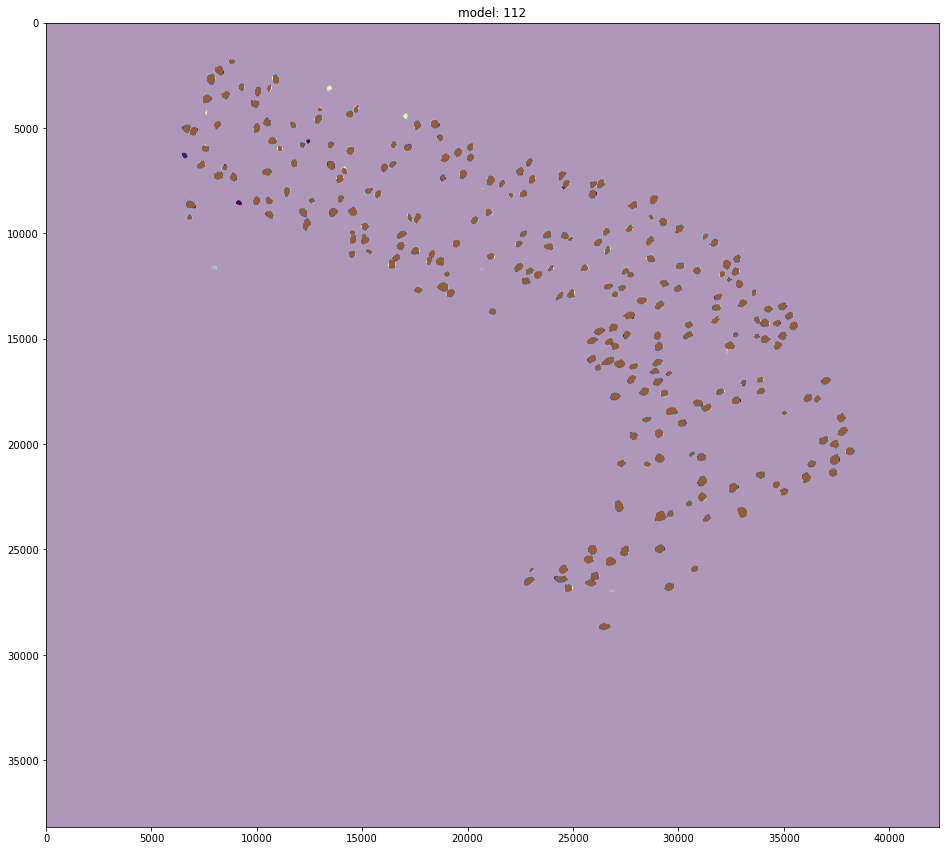

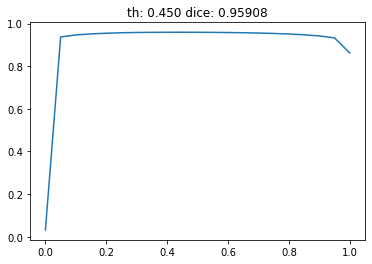

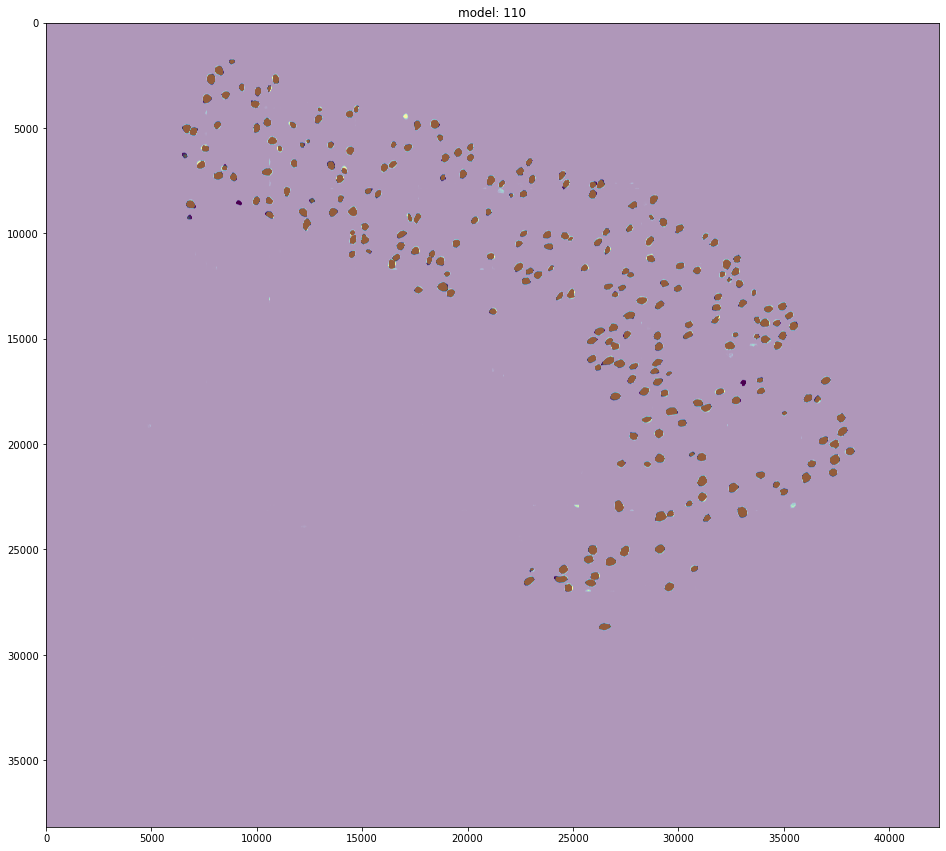

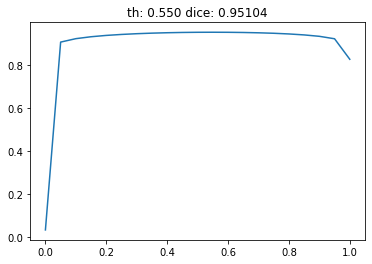

********************
2f6ecfcdf
(31278, 25794, 3)
(31278, 25794, 3)
(31278, 25794)
(31278, 25794)
dice_coef: 0.9597454001728722


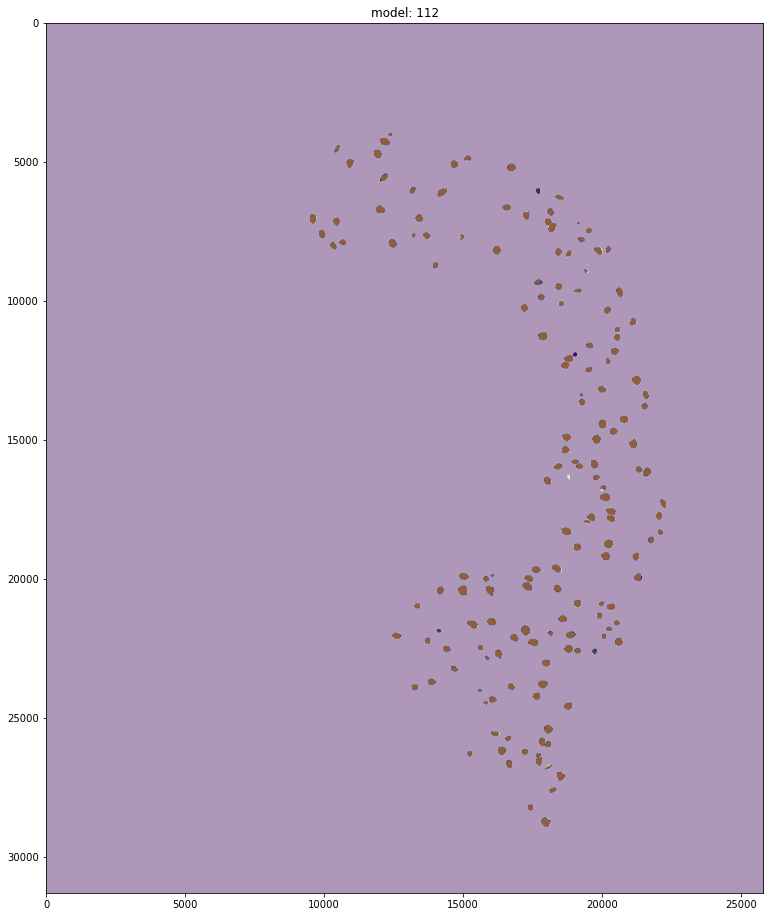

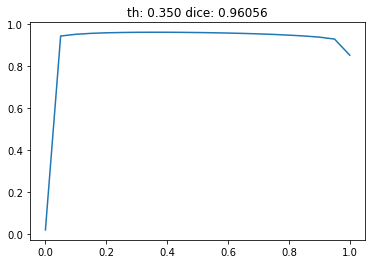

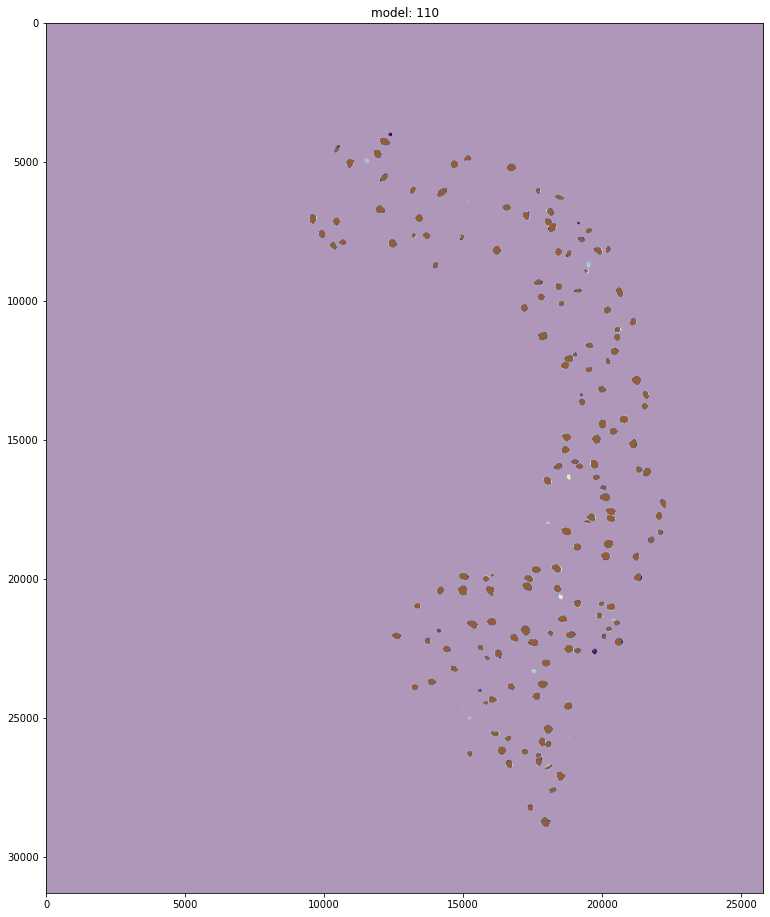

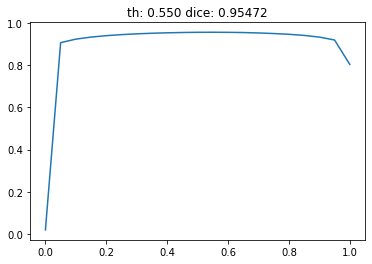

********************
54f2eec69
(1, 1, 3, 30440, 22240)
(30440, 22240, 3)
(30440, 22240)
(30440, 22240)
dice_coef: 0.9459755615562693


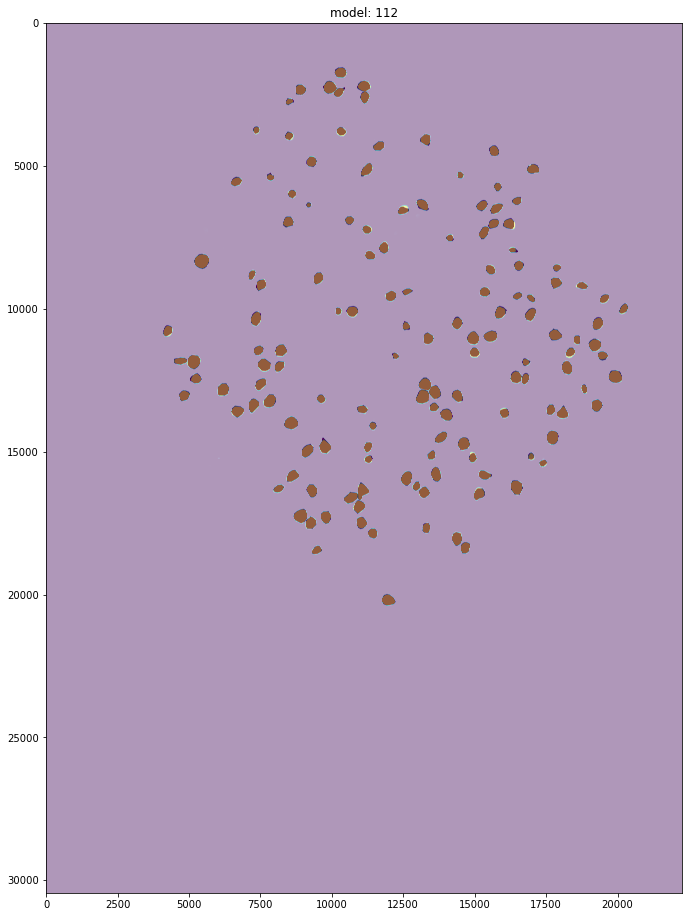

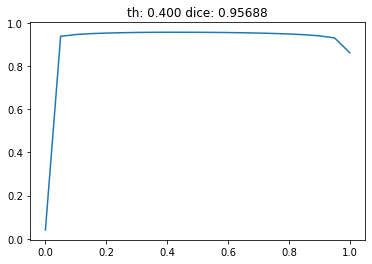

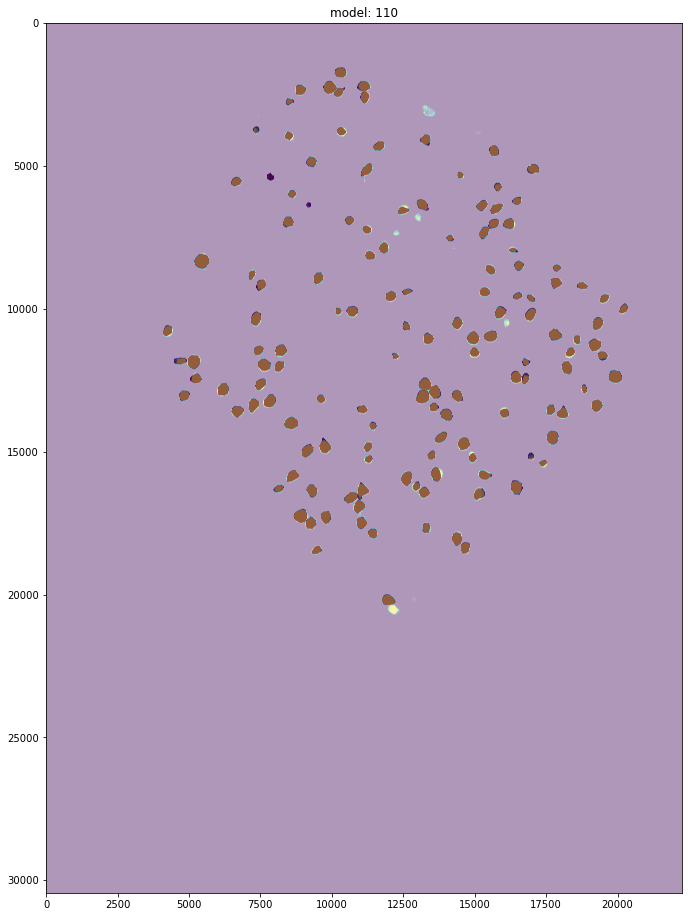

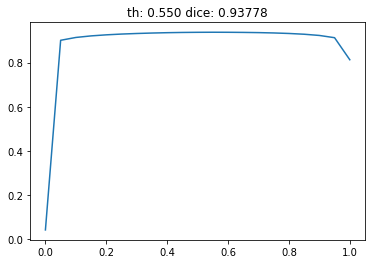

average dice_coef:0.9233428657169923
time elapsed: 51 min, 14 sec


In [26]:
if not KAGGLE:
    dices = []
    PLOT = True
    for i in df_sub.index:
        if not TEST:
            mdlsstr = ""
            for VER in VERS:
                    mdlsstr += f"{VER}-"
            threshstr = ""
            for THRESH in THRESHOLD:
                 threshstr += f"{int(THRESH*100)}-"
            df_masks = pd.read_csv(f"{DATA_PATH}/train.csv").set_index("id")
            idx = df_sub.iloc[i].id
            img = tiff.imread(os.path.join(SUB_PATH, idx + ".tiff"))
            print("*" * 20)
            print(idx)
            print(img.shape)
            if len(img.shape) == 5: img = img.squeeze()
            if img.shape[0] == 3: img = np.transpose(img.squeeze(), (1, 2, 0))
            msk_p = enc2mask([df_sub.iloc[i].predicted], (img.shape[1], img.shape[0]))
            msk = enc2mask([df_masks.loc[idx, "encoding"]], (img.shape[1], img.shape[0]))
            print(img.shape)
            print(msk_p.shape)
            print(msk.shape)
            dice = get_dice(msk_p, msk)
            print(f"dice_coef: {dice}")
            dices.append([dice, msk_p.shape[0]* msk_p.shape[1]])
            
            if PLOT:
                #plt.figure(figsize = (16, 16))
                #plt.imshow(img)
                #plt.imshow(msk, alpha = 0.3)
                #plt.title(idx)
                #plt.show()

                #plt.figure(figsize = (16, 16))
                #plt.figure(figsize = (16, 16))
                #plt.imshow(img)
                #plt.imshow(msk_p, alpha = 0.3)
                #plt.title(idx)
                #plt.show()
                if PLT_RAW:
                    for VER in VERS:
                        mask_lrg = complete_results[idx][VER]
                        plt.figure(figsize = (16,16))
                        plt.imshow(msk, cmap = "BuPu")
                        plt.imshow(mask_lrg.astype(np.float32), alpha = 0.4)
                        plt.title(f"model: {VER}")
                        plt.show()
                        plt.close()
                        
                        thresholds,dices1, n_max = get_best_th_dice(msk, mask_lrg, n=21, plot = False)
                        plt.plot(thresholds, dices1)
                        plt.title(f"th: {thresholds[n_max]:.3f} dice: {dices1[n_max]:.5f}")
                        plt.show()
                        plt.close()
                        del mask_lrg, dices1; gc.collect()
                
                
#                 plt.figure(figsize = (16, 16))
#                 plt.imshow(img)
#                 plt.imshow(msk, alpha = 0.4, cmap = "BuPu")
#                 plt.imshow(msk_p, alpha = 0.4)
#                 plt.title(idx)
#                 if len(VERS) == 1:
#                     save_path = PAR_DICT[VERS[0]]["MDL_PATH"]
#                 else:
#                     save_path = MDLS_PATH
#                 plt.savefig(f'{save_path}/{idx}-mdls-{mdlsstr}-cons-{CONSENSUS}-thr-{threshstr}-tta-{len(TTAS)}-dice-{int(dice*100000)}.jpeg', transparent=True, bbox_inches = 'tight',
#                                facecolor = 'k',pad_inches = 0)
#                 plt.show()
#                 plt.close()
                del msk, idx, img, msk_p; gc.collect()
        else:
            idx = df_sub.iloc[i].id
            img = tiff.imread(os.path.join(SUB_PATH, idx + ".tiff"))
            if len(img.shape) == 5: img = np.transpose(img.squeeze(), (1, 2, 0))
            if img.shape[0] == 3: img = np.transpose(img.squeeze(), (1, 2, 0))
            msk_p = enc2mask([df_sub.iloc[i].predicted], (img.shape[1], img.shape[0]))
            print(img.shape)
            print(msk_p.shape)
            plt.figure(figsize = (16, 16))
            plt.imshow(img)
            plt.imshow(msk_p, alpha = 0.4)
            
            plt.title(idx)
            plt.savefig(f'{save_path}/{idx}-mdls-{mdlsstr}-cons-{CONSENSUS}-thr-{threshstr}-tta-{len(TTAS)}-dice-{int(dice*100000)}.jpeg', transparent=True, bbox_inches = 'tight',
                               facecolor = 'k',pad_inches = 0)
            plt.show()
    if not TEST:
        coef = 0
        total = 0
        for dice in dices:
            coef += dice[0] * dice[1]
            total += dice[1]
        print(f"average dice_coef:{coef / total * 0.967}")

    elapsed_time = time.time() - start_time
    print(f"time elapsed: {elapsed_time // 60:.0f} min, {elapsed_time % 60:.0f} sec")